<a href="https://colab.research.google.com/github/emyesme/CalcificationDetection/blob/feature-pm/ML_structure_project_rus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Load the data



In [1]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

import os 

#first put a shortcut in your drive to the image processing folder

#Choose the image folder you want to try
pipeFolder = '10.Prepro+fixed+CorrectedLabels'

RESULTS_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results', 
                        pipeFolder)
                        #'15.CLAHE+Dehazing+Dil(3,3)+DoG(10)+LBP+GLCM')
#                        '10.CLAHE+Dehazing+Dil(3,3)+DoGTweak+GLCM')
                        # 'Pipeline10_HaarGLCMFeats')
                        #'10-1.CLAHE+Dehazing+Dil(3,3)+DoGTweak(0.06)+GLCM')
                        #'12.CLAHE+Dehazing+GrayMorph+Dil(3,3)+DoGTweak')

MODELS_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results', 
                        'MLModels')

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(RESULTS_DIR))

results_file = os.listdir(RESULTS_DIR)

['20586908_6c613a14b80a8591_MG_R_CC_ANON__fos_tb.csv', '20586934_6c613a14b80a8591_MG_L_CC_ANON__fos_tb.csv', '20586960_6c613a14b80a8591_MG_R_ML_ANON__fos_tb.csv', '20586986_6c613a14b80a8591_MG_L_ML_ANON__fos_tb.csv', '20587054_b6a4f750c6df4f90_MG_R_CC_ANON__fos_tb.csv', '20587080_b6a4f750c6df4f90_MG_R_ML_ANON__fos_tb.csv', '20587174_fd746d25eb40b3dc_MG_L_CC_ANON__fos_tb.csv', '20587148_fd746d25eb40b3dc_MG_R_CC_ANON__fos_tb.csv', '20587200_fd746d25eb40b3dc_MG_R_ML_ANON__fos_tb.csv', '20587294_e634830794f5c1bd_MG_R_CC_ANON__fos_tb.csv', '20587226_fd746d25eb40b3dc_MG_L_ML_ANON__fos_tb.csv', '20587320_e634830794f5c1bd_MG_L_CC_ANON__fos_tb.csv', '20587346_e634830794f5c1bd_MG_R_ML_ANON__fos_tb.csv', '20587372_e634830794f5c1bd_MG_L_ML_ANON__fos_tb.csv', '20587466_d571b5880ad2a016_MG_L_CC_ANON__fos_tb.csv', '20587492_d571b5880ad2a016_MG_R_ML_ANON__fos_tb.csv', '20587518_d571b5880ad2a016_MG_L_ML_ANON__fos_tb.csv', '20587544_d571b5880ad2a016_MG_R_CC_ANON__fos_tb.csv', '20587612_f4b2d377f43ba0bd_

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [5]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree

import numpy as np
from sklearn.datasets import load_digits
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
import pickle



In [7]:
from sklearn.ensemble import RandomForestClassifier # random forest
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import copy

In [8]:
import pandas as pd
import os
import cv2
#!pip install fastprogress
from fastprogress import master_bar, progress_bar
#!pip install tqdm
from tqdm.notebook import tqdm_notebook
from skimage import measure
from matplotlib import pyplot as plt

In [9]:
def read_results_train_test(path, keys):
  df_result = pd.DataFrame()
  for result in os.listdir(path):
    if result.split('.')[-1] == 'csv':
      if int(result.split('_')[0]) in list(keys):
        try:
          df = pd.read_csv(path+'/'+result)
          df_result = df_result.append(df)
        except:
          print("Empty file ", result)
  return df_result

In [10]:
def read_results(path):
  dfs = pd.DataFrame()
  for result in results_file:
    try:
      df = pd.read_csv(path+'/'+result)
    except:
      print("Empty file ", result)

    dfs = dfs.append(df)
  
  return dfs


In [11]:
def train_test_function():
  df_train_test = pd.read_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'standard_partitions.csv'), index_col=0)
  train_keys = df_train_test.loc[df_train_test.partition == 'train']['image_id'].values
  test_keys = df_train_test.loc[df_train_test.partition == 'test']['image_id'].values


  dfs_train = read_results_train_test(RESULTS_DIR, train_keys)
  dfs_test = read_results_train_test(RESULTS_DIR, test_keys)
  return dfs_train,dfs_test

In [12]:
# dfs_train, dfs_test = train_test_function()
# dfs_train.label.value_counts()

# **Preprocessing**

In [13]:
# We will balance data randomly taking  the same amount of 0 and 1 label inputs. There are several options to manage unbalanced data,
# this is just one approach, we should try different approaches.
# https://towardsdatascience.com/comparing-different-classification-machine-learning-models-for-an-imbalanced-dataset-fdae1af3677f
def rus(dfs, not_consider=0):
  # df_negative = dfs.loc[dfs.label == dfs.label.value_counts().idxmax()] #This is for making it more general
  df_negative = dfs.loc[dfs.label == 0] #Take all negative samples from dfs -> label = 0
  print('rus negative 1: ', len(df_negative))
  print('rus negative 1 without duplicates: ', len(df_negative.drop_duplicates()))
  #Here we are taking a subset from the 'negative pool' called df_negative with length equal to the number of positive candidates I have
  if not_consider >= len(dfs.loc[dfs.label == 1]):
    df_0 = pd.DataFrame()
  else:
    df_0 = df_negative.sample(len(dfs.loc[dfs.label == 1])-not_consider, random_state = 1) #not consider is the number of negative samples that I already have and that I misclassified the first time
  print('df_0: ', len(df_0))
  print('append ', len(df_negative.append(df_0)))
  print('df_negative drop no keeping', len(df_negative.drop_duplicates(keep=False)))
  df_negative = df_negative.append(df_0).drop_duplicates(keep=False) #df_negative is the samples that have not been used, and have not been selected yet for the training
  print('after drop duplicates with appended: ',len(df_negative))
  dfs_eq = df_0.append(dfs.loc[dfs.label == 1]) #dfs.label.value_counts().idxmin() #Here we are taking the balanced tada
  print("Length of balanced data: ", len(dfs_eq))
  print(dfs_eq['label'].value_counts())
  return dfs_eq, df_negative

In [14]:
def plotFeatures(data):
  #plot the scatter matrix
  pd.plotting.scatter_matrix(data,figsize=(25,25))
  #correlation plot
  corr = data.corr()
  f, ax = plt.subplots(figsize=(25, 25))
  sns.heatmap(corr,annot=True)

In [15]:
def standardScaler(X_train, X_test):
  standard_scaler = preprocessing.StandardScaler()
  X_train = standard_scaler.fit_transform(X_train)
  X_test = standard_scaler.transform(X_test)
  return X_train, X_test

# **Feature Engineering**

In [16]:
def featureSelectionTrees(estimators, X_train, y_train, X_test):
  clf = ExtraTreesClassifier(n_estimators=estimators)
  clf = clf.fit(X_train, y_train)
  model = SelectFromModel(clf, prefit=True)
  X_train = model.transform(X_train)
  X_test = model.transform(X_test)
  return X_train, X_test

In [17]:
def pcaAnalysis(components, X_train, X_test):
  pca = PCA(components)
  X_train = pca.fit_transform(X_train)
  X_test = pca.transform(X_test)
  print("PCA variance ratio: ", pca.explained_variance_ratio_)
  print("Total variance Explained by PCA: ", sum(pca.explained_variance_ratio_))
  return X_train, X_test

In [18]:
def selectFeaturesChi(k, X_train, X_test, y_train):
  sel = SelectKBest(chi2, k=k)
  sel.fit(X_train, y_train)
  X_train = sel.transform(X_train)
  X_test = sel.transform(X_test)
  return X_train, X_test

# **Classification**

In [19]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.base import clone
from sklearn.metrics import matthews_corrcoef

In [20]:
def cv_classification(classifier, params, X_train, X_test, y_train, y_test, clf_name):
  
  trainDataFull = pd.DataFrame(X_train).copy()
  trainDataFull['label'] = y_train

  dataBalanced, dfNegative = rus(trainDataFull)
  print("Data Balanced: ", len(dataBalanced))
  print("Negative pool: ",len(dfNegative))

  X_train_f1 = dataBalanced.drop('label', axis=1)
  y_train_f1 = dataBalanced['label']

  clf1 = clone(classifier)
  clf1.set_params(**params)
  cvf1Score = []
  cvMccScore = []
  cvpAUCScore = []

  selectedFold = 1

  print("******************** RESULTS Fold 1 *****************************")
  clf1.fit(X_train_f1, y_train_f1)
  print('Train')
  y_pred_tr_1 = clf1.predict(X_train_f1)
  print(confusion_matrix(y_train_f1, y_pred_tr_1))
  print(f1_score(y_train_f1, y_pred_tr_1))

  print('Test')
  y_pred_1 = clf1.predict(X_test)
  print(confusion_matrix(y_test, y_pred_1))
  print(f1_score(y_test, y_pred_1))
  print(classification_report(y_test, y_pred_1))  

  print('F1 score test: ', f1_score(y_test, y_pred_1, average='binary'))
  cvf1Score.append(f1_score(y_test, y_pred_1, average='binary'))
  cvMccScore.append(matthews_corrcoef(y_test, y_pred_1))
  cvpAUCScore.append(roc_auc_score(y_test, clf1.predict_proba(X_test)[:,1], max_fpr = 0.0001))

  print("*********************** RESULTS Fold 2 *******************************")
  trainDataFull = pd.DataFrame(X_test).copy()
  trainDataFull['label'] = y_test

  dataBalanced, dfNegative = rus(trainDataFull)
  print("Data Balanced: ", len(dataBalanced))
  print("Negative pool: ",len(dfNegative))

  X_test_f2 = dataBalanced.drop('label', axis=1)
  y_test_f2 = dataBalanced['label']

  clf2 = clone(classifier)
  clf2.set_params(**params)
  clf2.fit(X_test_f2, y_test_f2)

  print('Train')
  y_pred_tr_2 = clf2.predict(X_test_f2)
  print(confusion_matrix(y_test_f2, y_pred_tr_2))
  print(f1_score(y_test_f2, y_pred_tr_2))

  print('Test')
  y_pred_2 = clf2.predict(X_train)
  print(confusion_matrix(y_train, y_pred_2))
  print(f1_score(y_train, y_pred_2))
  print(classification_report(y_train, y_pred_2))  

  print('F1 score test: ', f1_score(y_train, y_pred_2, average='binary'))
  cvf1Score.append(f1_score(y_train, y_pred_2, average='binary'))
  cvMccScore.append(matthews_corrcoef(y_train, y_pred_2))
  cvpAUCScore.append(roc_auc_score(y_train, clf2.predict_proba(X_train)[:,1], max_fpr = 0.0001))

  print("Mean CV_score F1-score: ", np.mean(cvf1Score))

  # Choose the best one
  if np.array(cvf1Score).argmax() == 0:  

    y_pred_proba_tr = clf1.predict_proba(X_train_f1)[:, 1]
    print('pAUC train: ', roc_auc_score(y_train_f1, y_pred_proba_tr, max_fpr = 0.0001))

    y_pred_proba = clf1.predict_proba(X_test)[:, 1]
    print('pAUC test: ', roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001))
    
    best_f1 = f1_score(y_test, y_pred_1)
    best_mcc = matthews_corrcoef(y_test, y_pred_1)
    best_pAUC = roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001)

    final_clf = clf1
    
  else:
    y_pred_proba_tr = clf2.predict_proba(X_test_f2)[:, 1]
    print('pAUC train: ', roc_auc_score(y_test_f2, y_pred_proba_tr, max_fpr = 0.0001))


    y_pred_proba = clf2.predict_proba(X_train)[:, 1]
    print('pAUC test: ', roc_auc_score(y_train, y_pred_proba, max_fpr = 0.0001))

    best_f1 = f1_score(y_train, y_pred_2)
    best_mcc = matthews_corrcoef(y_train, y_pred_2)
    best_pAUC = roc_auc_score(y_train, y_pred_proba, max_fpr = 0.0001)    

    final_clf = clf2
    selectedFold=2

  print("Best fold is {}".format(selectedFold))

  filename = f'best_model_{clf_name}_{selectedFold}_rus.pkl'
  pickle.dump(final_clf, open(os.path.join(MODELS_DIR,'rus', filename), 'wb'))
  print(f"Fold {selectedFold} of {clf_name} was saved!")  

  print('y_pred_proba: ', len(y_pred_proba))

  return y_pred_proba, y_pred_proba_tr, selectedFold, final_clf, [np.mean(cvpAUCScore), np.mean(cvf1Score), np.mean(cvMccScore)], [best_pAUC, best_f1, best_mcc]

In [21]:

def RandomForest(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    print("Searching for best hyperparameters")
    params = {'criterion': ['gini'],
              'n_estimators': [100], # , 500, 900
              'max_features': ['auto', 'sqrt'],#, 'sqrt', 'log2'
              'max_depth' : [10, 12]}
    grid = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs = -1), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for rf are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = RandomForestClassifier(random_state=42, n_jobs = -1)
  
  return classifier, best_params

In [22]:
from sklearn.ensemble import GradientBoostingClassifier # gradient boosting regressor
# https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
def GradientBoosting(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'learning_rate': [0.1],#0.05, 0.2
              #'min_samples_split': [0.5, 0.8],
              #'min_samples_leaf': [0.1, 0.2, 0.5],
              'max_depth':[8],
              #'max_features':['sqrt'],#'log2'
              #'criterion': ['friedman_mse',  'mae'],
              #'subsample':[0.5, 1.0],
              'n_estimators':[600]}
    grid = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for gb are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))

  classifier = GradientBoostingClassifier(random_state=42)
  
  return classifier, best_params

In [23]:
from sklearn.ensemble import AdaBoostClassifier # adaboost, adaboostRegressor for regression problems

def AdaBoost(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'n_estimators': [600],
              'learning_rate': [0.5]}
    grid = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for ab are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = AdaBoostClassifier(random_state=42)

  return classifier, best_params

In [24]:
from sklearn.linear_model import LogisticRegression

def LogRegre(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'multi_class':['multinomial'],
              'solver': ['sag'],#,'saga'
              'penalty': ['l2']}#'elasticnet',
    grid = GridSearchCV(LogisticRegression(random_state=42), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for lrg are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = LogisticRegression(random_state=42)
  
  return classifier, best_params

In [25]:
def KNN(X_train, y_train, cv=5, best_params = dict()):
  if len(best_params) == 0:
    params = {'neighbors':[3,5]}
    grid = GridSearchCV(KNeighborsClassifier(random_state=24), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

  classifier = KNeighborsClassifier(random_state=24)

  return classifier, best_params

In [26]:
def DecisionTree(X_train, y_train, cv=5, best_params = dict()):
  classifier = tree.DecisionTreeClassifier()
 

  return classifier, best_params

In [27]:
# This is an example of how to use a Pipe inside a function we are training, as done in Challenge 3 by the professor
def SVC_linear(X_train, y_train, cv=5, best_params = dict()):

  if len(best_params) == 0:
    lower_value_C = 1
    higher_value_C = 10
    n_values = 10
    base = 10
    params = {'C': [1, 3, 5,9.11], #12
              'kernel' : ['rbf'],
              'gamma': [2.5, 5, 10]}

    grid = GridSearchCV(SVC(random_state = 42, probability=True), param_grid=params, cv=cv, n_jobs=-1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_

    print("The best parameters for svm are %s with an accuracy of %0.4f"%(best_params, grid.best_score_))
  
  classifier = SVC(random_state = 42, probability=True)

  return classifier, best_params

In [28]:
def negative_pool(dataBalanced, dfNegative, hyperOptBalanceData, X_test, y_test, classifier, hyperParam=dict()):
  count = 0
  f1_scores = []
  pAUCs = []

  trainBalanceData = dataBalanced.drop('label', axis=1)
  trainBalanceLabel = dataBalanced['label']

  hyperOptTrainData = hyperOptBalanceData.drop('label', axis=1)
  hyperOptLabel = hyperOptBalanceData['label']


# Test on the training set to check for overfitting
# We can try with a cascade - Viola Jones
# Adaboost for classifier - Rankboost
# Nor PCA because not a lot of features
# Correlation check.

  while True:

    #Classification

    if count==0:

      print(f"First iteration {classifier}... looking for best hyperparameters")

      if classifier == 'svm':
        clf, best_params = SVC_linear(hyperOptTrainData, hyperOptLabel, best_params = hyperParam)
      elif classifier == 'rf':
        clf, best_params = RandomForest(hyperOptTrainData, hyperOptLabel, best_params = hyperParam)
      elif classifier == 'gb':
        clf, best_params = GradientBoosting(hyperOptTrainData, hyperOptLabel, best_params = hyperParam)
      elif classifier == 'adaboost':
        clf, best_params = AdaBoost(hyperOptTrainData, hyperOptLabel, best_params = hyperParam)
      elif classifier == 'logreg':
        clf, best_params = LogRegre(hyperOptTrainData, hyperOptLabel, best_params = hyperParam)
      elif classifier == 'knn':
        clf, best_params = KNN(hyperOptTrainData, hyperOptLabel, best_params = hyperParam)
      elif classifier == 'dt':
        clf, best_params = DecisionTree(hyperOptTrainData, hyperOptLabel,best_params = hyperParam)
      clf.set_params(**best_params)    

    
    clf.fit(trainBalanceData, trainBalanceLabel)
    pred = clf.predict(trainBalanceData)
    print('F1-score train: ', f1_score(trainBalanceLabel, pred))
    y_pred_proba_tr = clf.predict_proba(trainBalanceData)[:, 1]
    print('pAUC train: ', roc_auc_score(trainBalanceLabel, y_pred_proba_tr, max_fpr = 0.0001))


    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)[:, 1]

    print('F1-score test: ', f1_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    print('pAUC test: ', roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001))
    pAUCs.append(roc_auc_score(y_test, y_pred_proba, max_fpr = 0.0001))


    misclassified = pd.DataFrame(columns = trainBalanceData.columns)
    labels_pool = []
    print(len(pred))
    print(len(trainBalanceLabel))
    for i in range(len(pred)):
      if (pred[i]==1) & (trainBalanceLabel.iloc[i] == 0): #FP False positive
#        new_row = pd.DataFrame(X_test[i].reshape(1, data.shape[1] ), columns=data.columns)
        new_row = trainBalanceData.iloc[i]
        misclassified = misclassified.append(new_row)
        labels_pool.append(trainBalanceLabel.iloc[i])

    dfPositive = dataBalanced.loc[dataBalanced.label == 1]

    if len(dfPositive)*0.9 >= (len(dfNegative)+len(misclassified)):
      print("Negative pool is too short...")
      print("Len of positive samples: ", len(dfPositive))
      print("Len of negative samples: ", len(dfNegative)+len(misclassified))
      break

    if (len(f1_scores) > 5 and (f1_scores[-1] - f1_scores[-2])< 0.001): 
      print('last ', f1_scores[-1])
      print('second last ', f1_scores[-2])
      print("No significant change in 5 iterations. Escaping")
      break

    dataBalanced, dfNegative = rus(dfPositive.append(dfNegative), len(misclassified)) #Get a new pool of dfNegative
    
    trainBalanceLabel = dataBalanced['label'].append(pd.Series(labels_pool))
    trainBalanceData = dataBalanced.drop(['label'], axis=1).append(misclassified)

    print('Data len: ', len(trainBalanceData))
    print('labels len: ', len(trainBalanceLabel))
    
    count +=1

  return clf, best_params, y_pred_proba

# **Scores**

In [29]:
import os 

#first put a shortcut in your drive to the image processing folder

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(DATA_DIR))

['normals.txt', 'images', 'groundtruths', 'masks']


In [30]:
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

In [31]:
import cv2

def calculateFROC(groundTruthsList, normals, candidates, prediction, model, pipeline):

  #List needed for counting
  evaluationList = []

  # evaluation froc curve #

  fn = 0 # false negative, for the blobs that do not belong to any component
  positive_candidates = 0
  flag = True

  rowListdfROC = []

  candidates_copy= candidates.copy()
  candidates_copy['prediction'] = prediction

  for imageKey in tqdm_notebook(groundTruthsList):


    evaluationList = []
 
    # list of features found with y,x and sigma
    candidatesImg = candidates_copy.loc[candidates_copy['name'].str.contains(imageKey.split('_')[0], regex=False)]
    candidates_number = len(candidatesImg)
    print('cand number: ', candidates_number)

    mask = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', imageKey), cv2.IMREAD_GRAYSCALE)

 #   print('# IMAGEKEY: ', imageKey)
    blobs = mask > 0.7 * mask.mean() #Thresholding the backgroudnd
    blobs_labels, count = measure.label(blobs, background=0, return_num=True) #Getting labels of the connected components and the amount of them without considering the count

    # dictionaries
    dictCounting={}

  #  print(count)
    for index in range(1, count+1):
      dictCounting[index] = 0
    
    evaluationList = []

    for index2, candidate in candidatesImg.iterrows():
      sigma = 7

      if (imageKey.split('_')[0] in normals):
        rowListdfROC.append(['FP', candidate.prediction])  
        continue
      # is the image a normal image?

      if (((candidate.x - sigma) < 0) or 
        ((candidate.x + sigma) > mask.shape[0]) or 
        ((candidate.y - sigma) < 0) or
        ((candidate.y + sigma) > mask.shape[1])):
        continue


      # n = 3
      left = int(candidate.x - sigma)
      right = int(candidate.x + sigma)
      top = int(candidate.y - sigma)
      bottom = int(candidate.y + sigma) 

      #    y : y + w , x : x +  h
      nonzero = cv2.countNonZero(blobs_labels[top:bottom, left: right])

      if nonzero > 0:
        # Find all connected components (cc) that intersect with the candidate
        foundCC = [i for i in np.unique(blobs_labels[top:bottom, left: right]) if i!= 0]

        # Keep the maximum prediction of the candidates that intsersect with at least one component
        for cc in foundCC:
          dictCounting[cc] = max(candidate.prediction, dictCounting[cc])

    if (imageKey.split('_')[0] not in normals):
        for key,value in dictCounting.items():
          if np.sum(blobs_labels == key) > np.floor(np.pi*(15/2.0)**2):
            print("Too big... discarded")
            continue
          if value > 0:
              rowListdfROC.append(['TP', value])
          else:
            fn = fn + 1

  filename_key = 'FROC_calculations_{}_pip{}_fn{}_normals{}_rus.csv'.format(model, pipeline, fn, len(normals))

  dfROC = pd.DataFrame(rowListdfROC, columns=['type', 'prob'])

  dfROC.to_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'MLModels',
                                'rus',
                                filename_key))
  
  print("File saved as ", filename_key)



  return fn, dfROC, filename_key

In [32]:
def writeFile(df, flag, name):
  if(flag):
    df.to_csv(os.path.join('/content',
                                 'drive',
                                 'MyDrive',
                                 'Results',
                                 name),
                    mode='a',
                    index=False)
    flag = False
  else:
    df.to_csv(os.path.join('/content',
                                 'drive',
                                 'MyDrive',
                                 'Results',
                                 name),
                  mode='a',
                  header=False,
                  index=False)
  return flag

In [33]:
import matplotlib.pyplot as plt
from numpy import trapz

def draw_curve(fn, normals, dfROC, name, clf_name):

  experiments_results_path = os.path.join(MODELS_DIR, 'rus')
  results_filename = f'results_AUC_rus_{pipeFolder}.csv'

  if results_filename not in os.listdir(experiments_results_path):
    results_df = pd.DataFrame(columns=["model", "AUC_TOTAL", "AUC_final_50fPpi"])
    results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)
  else:
    results_df = pd.read_csv(os.path.join(experiments_results_path, results_filename))

  tpc = 0
  fpc = 0
  tpr = []
  fppi = []

  dfROC['prob'] = [round(i,4) for i in dfROC['prob'].values]
  dfROC = dfROC.sort_values('prob', ascending=False)

  thresholds = dfROC.prob.unique()
  print('Number of thresholds: ', len(thresholds))
  print(thresholds)


  tp = len(dfROC.loc[dfROC.type == 'TP'])
  print('true positives: ', tp)

  print('false positives: ',  len(dfROC.loc[dfROC.type == 'FP']))

  print("Total number of positives: ", tp+fn)

  for i in progress_bar(range(len(thresholds))):

    tpc += len(dfROC.loc[(dfROC.prob > thresholds[i]) & (dfROC.type=='TP')])
    fpc += len(dfROC.loc[(dfROC.prob > thresholds[i]) & (dfROC.type!='TP')])
              
    # print('TP amount {} in threshold {}'.format(tpc, thresholds[i]))
    # print('FP amount {} in threshold {}'.format(fpc, thresholds[i]))
    

    tpr.append( tpc/(tp+fn) )
    fppi.append( fpc/normals )
    tpc = 0
    fpc = 0
  
  gamma = [i for i in fppi if i <= 50 ]
  auc_total = trapz(tpr, x=fppi)/max(fppi)
  auc_final = trapz(tpr[0:len(gamma)], x=gamma)/max(gamma)

  print('AUC TOTAL:', auc_total)
  fig, ax = plt.subplots()
  ax.plot(fppi, tpr)
  ax.set_xlabel('fPpI', fontsize=15)
  ax.set_ylabel('TPR', fontsize=15)
  ax.grid(True)
  plt.ylim(0,1)
  plt.show()


  print('AUC final:', auc_final)
  fig1, ax1 = plt.subplots()
  ax1.plot(gamma, tpr[0:len(gamma)])
  ax1.set_xlabel('fPpI', fontsize=12)
  ax1.set_ylabel('TPR', fontsize=12)
  ax1.grid(True)
  plt.ylim(0,1)
  plt.xlim(0,50)

  plt.savefig(os.path.join('/content',
                          'drive',
                          'MyDrive',
                          'Results',
                          'MLModels',
                          'rus', 
                           name+'.eps'), format='eps')
    

  row_results = [clf_name, auc_total, auc_final]
  results_df = results_df.append(pd.DataFrame([row_results], columns=["model", "AUC_TOTAL", "AUC_final_50fPpi"]))
  results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)




# **Main**

In [34]:
# https://medium.com/@robertbracco1/configuring-google-colab-like-a-pro-d61c253f7573#a642
%%javascript
function ConnectButton(){
    console.log("Connect pushed"); 
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);

<IPython.core.display.Javascript object>

**Cross validation classification**

Length of train set:  5198275
Length of test set:  5461275
Train dfs without nans:  5196897
Test dfs without nans:  5459791
rus negative 1:  5131189
rus negative 1 without duplicates:  5124310
df_0:  65708
append  5196897
df_negative drop no keeping 5122112
after drop duplicates with appended:  5056518
Length of balanced data:  131416
0    65708
1    65708
Name: label, dtype: int64
Data Balanced:  131416
Negative pool:  5056518
The best parameters for ab are {'learning_rate': 0.5, 'n_estimators': 600} with an accuracy of 0.9906
rus negative 1:  5131189
rus negative 1 without duplicates:  5124310
df_0:  65708
append  5196897
df_negative drop no keeping 5122112
after drop duplicates with appended:  5056518
Length of balanced data:  131416
0    65708
1    65708
Name: label, dtype: int64
Data Balanced:  131416
Negative pool:  5056518
******************** RESULTS Fold 1 *****************************
Train
[[43989 21719]
 [22344 43364]]
0.6631037303790016
Test
[[3602311 1822449]
 [  13150   

  0%|          | 0/210 [00:00<?, ?it/s]

cand number:  23964
Too big... discarded
Too big... discarded
cand number:  20384
cand number:  33177
Too big... discarded
cand number:  22163
Too big... discarded
cand number:  27774
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
Too big... discarded
cand number:  13144
cand number:  36993

AUC TOTAL: 0.8172200331338375


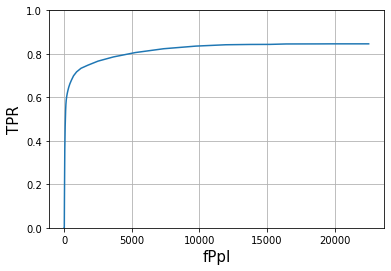

AUC final: 0.22765409005126322
Searching for best hyperparameters


In [ ]:
# def main():
from sklearn.utils import shuffle


classifiers = ['adaboost' , 'rf', 'svm']
best_hyperparameters = dict()
y_pred_proba = []
f1_scores = []

experiments_results_path = os.path.join(MODELS_DIR, 'rus')
results_filename = f'results_rus_{pipeFolder}.csv'

if results_filename not in os.listdir(experiments_results_path):
  results_df = pd.DataFrame(columns=["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"])
  results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)
else:
  results_df = pd.read_csv(os.path.join(experiments_results_path, results_filename))

#Reading data
dfs_train, dfs_test = train_test_function()

dfs_tr_hyperopt = dfs_train.sample(frac=0.1, random_state=42)
dfs_ts_hyperopt = dfs_test.sample(frac=0.1, random_state=42)

dfs_train = dfs_train.append(dfs_tr_hyperopt).drop_duplicates(keep=False)
dfs_test = dfs_test.append(dfs_ts_hyperopt).drop_duplicates(keep=False)
print('Length of train set: ', len(dfs_train))
print('Length of test set: ', len(dfs_test))


dfs_hyperOpt = shuffle(dfs_tr_hyperopt.append(dfs_ts_hyperopt))


#Preprocessing steps
#Manage unbalanced data
# dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

try:
  if dfs_train.isnull().values.any():
    colm = dfs_train.columns[dfs_train.isna().any()]
    dfs_train = dfs_train[dfs_train[colm[0]].notna()]

  if dfs_test.isnull().values.any():
    colm = dfs_test.columns[dfs_test.isna().any()]    
    dfs_test = dfs_test[dfs_test[colm[0]].notna()]

  if dfs_hyperOpt.isnull().values.any():
    colm = dfs_hyperOpt.columns[dfs_hyperOpt.isna().any()]
    dfs_hyperOpt = dfs_hyperOpt[dfs_hyperOpt[colm[0]].notna()]


  print("Train dfs without nans: ", len(dfs_train))
  print("Test dfs without nans: ",len(dfs_test))

except Exception as e:
  print("No nan values to drop, or not columns")
  print(e)

y_train = dfs_train['label'].reset_index(drop=True)
candidates_train = dfs_train[['name', 'label', 'x', 'y']].reset_index(drop=True)
X_train = dfs_train.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)

y_test = dfs_test['label'].reset_index(drop=True)
candidates_test = dfs_test[['name', 'label', 'x', 'y']].reset_index(drop=True)
X_test = dfs_test.drop(['name', 'label',  'x', 'y'], axis=1).reset_index(drop=True)


#Plot features 
#  plotFeatures(data)

#Obtain train-test datasets


trainDataFull = pd.DataFrame(X_train).copy()
trainDataFull['label'] = y_train

dataBalanced, dfNegative = rus(trainDataFull)
print("Data Balanced: ", len(dataBalanced))
print("Negative pool: ",len(dfNegative))

trainBalanceData = dataBalanced.drop('label', axis=1)
trainBalanceLabel = dataBalanced['label']

hyperOptTrainData = dfs_hyperOpt.drop(['name', 'label',  'x', 'y'], axis=1)
hyperOptLabel = dfs_hyperOpt['label']


for classifier in classifiers:

  if classifier == 'svm':
    clf, best_params = SVC_linear(hyperOptTrainData, hyperOptLabel)
  elif classifier == 'rf':
    clf, best_params = RandomForest(hyperOptTrainData, hyperOptLabel)
  elif classifier == 'gb':
    clf, best_params = GradientBoosting(hyperOptTrainData, hyperOptLabel, best_params = {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600})
  elif classifier == 'adaboost':
    clf, best_params = AdaBoost(hyperOptTrainData, hyperOptLabel)
  elif classifier == 'logreg':
    clf, best_params = LogRegre(hyperOptTrainData, hyperOptLabel)
  elif classifier == 'knn':
    clf, best_params = KNN(hyperOptTrainData, hyperOptLabel)
  elif classifier == 'dt':
    clf, best_params = DecisionTree(hyperOptTrainData, hyperOptLabel)


  y_pred_proba, y_pred_proba_tr, selectedFold, clf_trained, mean_metrics, best_metrics = cv_classification(clf, best_params, X_train, X_test, y_train, y_test, classifier)
# Columns of results file are ["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"]
  results_to_save = [classifier]
  results_to_save.extend(mean_metrics)
  results_to_save.extend(best_metrics)
  results_to_save.append(selectedFold)
  results_to_save.append([best_params])

  #save Results file in already created file
  results_df = results_df.append(pd.DataFrame([results_to_save], columns = ["model", "pAUC_mean", "f1_mean", "mcc_mean", "pAUC", "f1", "mcc", "selectedFold", "parameters"] ))
  results_df.to_csv(os.path.join(experiments_results_path, results_filename), index=False)

  best_hyperparameters[classifier] = best_params


  normals = []
  with open(os.path.join(DATA_DIR,'normals.txt')) as f:
      for line in f:
          normals.append(line[:-1])

  if selectedFold == 1:
    candidates_unique = [cand.split('_')[3] for cand in candidates_test['name'].values.tolist()]
    selected_candidates = candidates_test
  else:
    candidates_unique = [cand.split('_')[3] for cand in candidates_train['name'].values.tolist()]
    selected_candidates = candidates_train

  candidates_unique = list(set(candidates_unique))

  groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]

  print(len(groundTruthShort))

  normals = [i for i in normals if i in candidates_unique]

  prob_predictions = y_pred_proba
  fn, dfROC, filename_key = calculateFROC(groundTruthShort, normals, selected_candidates, prob_predictions, classifier, RESULTS_DIR.split('/')[-1].split('.')[0]+'_method2')
  print(len(dfROC.prob.unique()))
  draw_curve(fn, len(normals), dfROC, filename_key.split('.')[0], classifier)




In [36]:
results_to_save

['gb',
 0.5023593643222048,
 0.042012270388080315,
 0.07968749791029817,
 0.5014668584884112,
 0.05368239715192274,
 0.09067190264058457,
 2,
 [{'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 600}]]

In [ ]:
# def main():


classifier = 'SVM_SEL'
y_pred_proba = []
f1_scores = []

#Reading data
dfs_train, dfs_test = read_results_train_test(RESULTS_DIR)
print(len(dfs_train))
print(len(dfs_test))

#Preprocessing steps
#Manage unbalanced data
# dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

y_train = dfs_train['label'].reset_index(drop=True)
candidates_train = dfs_train[['name', 'label', 'x', 'y', 'sigma']].reset_index(drop=True)
X_train = dfs_train.drop(['name', 'label',  'x', 'y', 'sigma'], axis=1).reset_index(drop=True)

y_test = dfs_test['label'].reset_index(drop=True)
candidates_test = dfs_test[['name', 'label', 'x', 'y', 'sigma']].reset_index(drop=True)
X_test = dfs_test.drop(['name', 'label',  'x', 'y', 'sigma'], axis=1).reset_index(drop=True)


#Plot features 
#  plotFeatures(data)

#Obtain train-test datasets

if classifier == "SVM_SEL":
  counter = 0
  # print('Len of negative pool: ',len(dfNegative))
  # X_train, X_test, y_train, y_test, candidates_train, candidates_test = train_test_split(data, labels, candidates, test_size=0.5,  stratify=labels,random_state=42)  

  # Normalization steps
  # X_train, X_test = standardScaler(X_train, X_test)

  #Feature Engineering - PCA, LDA, choose-k, etc
  # X_train, X_test = pcaAnalysis(10, X_train, X_test)

  trainDataFull = pd.DataFrame(X_train)
  trainDataFull['label'] = y_train

  dataBalanced, dfNegative = rus(trainDataFull)
  print("Data Balanced: ", len(dataBalanced))
  print("Negative pool: ",len(dfNegative))


  trainBalanceData = dataBalanced.drop('label', axis=1)
  trainBalanceLabel = dataBalanced['label']


#  while len(dfNegative)>(len(dataBalanced)/2)

# Test on the training set to check for overfitting
# We can try with a cascade - Viola Jones
# Adaboost for classifier - Rankboost
# Nor PCA because not a lot of features
# Correlation check.

  while True:

    #Classification

    if counter == 0:
      print("Trying SMV SEL...")
      best_params = SVM_SEL(13, -2, 10, trainBalanceData, trainBalanceLabel, kfold_number=10)
      clf = SVC(**best_params, probability = True)

    clf.fit(trainBalanceData, trainBalanceLabel)
    pred = clf.predict(trainBalanceData)

    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)
    y_pred_proba = [i[1] for i in y_pred_proba]
    print('F1-score: ', f1_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

    misclassified = pd.DataFrame(columns = trainBalanceData.columns)
    labels_pool = []
    for i in range(len(pred)):
      if (pred[i]==1) & (trainBalanceLabel.iloc[i] == 0): #FP False positive
#        new_row = pd.DataFrame(X_test[i].reshape(1, data.shape[1] ), columns=data.columns)
        new_row = trainBalanceData.iloc[i]
        misclassified = misclassified.append(new_row)
        labels_pool.append(trainBalanceLabel.iloc[i])

    dfPositive = dataBalanced.loc[dataBalanced.label == 1]

    if len(dfPositive)*0.9 >= (len(dfNegative)+len(misclassified)):
      print("Negative pool is too short...")
      print("Len of positive samples: ", len(dfPositive))
      print("Len of negative samples: ", len(dfNegative)+len(misclassified))
      break


    if len(f1_scores) > 5:
      f1_scores.sort()
      print('last ', f1_scores[-1])
      print('second last ', f1_scores[-2])
      print("No significant change in 5 iterations. Escaping")
      break

    dataBalanced, dfNegative = rus(dfPositive.append(dfNegative), len(misclassified)) #Get a new pool of dfNegative
    
    trainBalanceLabel = dataBalanced['label'].append(pd.Series(labels_pool))
    trainBalanceData = dataBalanced.drop(['label'], axis=1).append(misclassified)

    print('Data len: ', len(trainBalanceData))
    print('labels len: ', len(trainBalanceLabel))
    counter +=1

elif classifier == 'DT':

    dataBalanced, dfNegative = rus(dfs_train) #Random majority undersampling

    # y_train = dfs_train['label'].reset_index(drop=True)
    # X_train = dfs_train.drop(['name', 'label',  'x', 'y', 'sigma'], axis=1).reset_index(drop=True)  
    # candidates_train = dfs_train[['name', 'label', 'x', 'y', 'sigma']]

    # Normalization steps
    X_train, X_test = standardScaler(X_train, X_test)


    # SVC_linear(5, -2,2, 10, data, labels)
    y_pred_proba, selectedFold = DecisionTree(X_train, X_test, y_train, y_test)
  # print(predDT)
elif classifier == 'KNN':
    predKNN = KNN(5, X_train, X_test, y_train, y_test, data, labels)



  

  
  # df = df.drop(410)
  # groundTruthsDataFrame = groundTruthsDataFrame.drop([410, 411,412, 413, 414, 415])


  # read numbers of normal images

#Try the tes

In [ ]:
f1_scores

In [ ]:
selectedFold = 1


normals = []
with open(os.path.join(DATA_DIR,'normals.txt')) as f:
    for line in f:
        normals.append(line[:-1])

if selectedFold == 1:
  candidates_unique = [cand.split('_')[2] for cand in candidates_test['name'].values.tolist()]
  selected_candidates = candidates_test
else:
  candidates_unique = [cand.split('_')[2] for cand in candidates_train['name'].values.tolist()]
  selected_candidates = candidates_train
candidates_unique = list(set(candidates_unique))
# df_candidates_unique = pd.DataFrame()
# df_candidates_unique['key'] = candidates_unique

# groundTruthsDataFrame['key'] = [i.split('_')[0] for i in groundTruthsDataFrame['name'].values.tolist()]

# groundTruthsDataFrame = groundTruthsDataFrame.join(df_candidates_unique.set_index('key'), on='key', how='right')

groundTruthShort = [i for i in groundTruths if i.split('_')[0] in candidates_unique]

print(len(groundTruthShort))

normals = [i for i in normals if i in candidates_unique]


prob_predictions = y_pred_proba
calculateFROC(groundTruthShort, normals, selected_candidates, prob_predictions, 'SVM-SEL', '10')
fn, dfROC = calculateFROC(groundTruthShort, normals, selected_candidates, prob_predictions, 'SVM-SEL', '10')



205


  0%|          | 0/205 [00:00<?, ?it/s]

cand number:  5912
# IMAGEKEY:  30011798_4f20c1285d8f0b1f_MG_R_CC_ANON.tif
10
cand number:  2767
# IMAGEKEY:  30318067_4f20c1285d8f0b1f_MG_L_ML_ANON.tif
7
cand number:  2799
# IMAGEKEY:  50994273_cc9e66c5b31baab8_MG_R_CC_ANON.tif
0
cand number:  4690
# IMAGEKEY:  50997277_9054942f7be52dd9_MG_L_CC_ANON.tif
51
cand number:  6469
# IMAGEKEY:  50998204_f34ee0ab6591b792_MG_R_ML_ANON.tif
4
cand number:  5947
# IMAGEKEY:  50998981_a78eba834ef6ee88_MG_R_ML_ANON.tif
4
cand number:  2551
# IMAGEKEY:  51048891_f3e93e889a7746f0_MG_L_ML_ANON.tif
3
cand number:  6864
# IMAGEKEY:  51049053_8c105bb715bf1c3c_MG_L_ML_ANON.tif
14
cand number:  7092
# IMAGEKEY:  51049134_8c105bb715bf1c3c_MG_R_CC_ANON.tif
37
cand number:  3370
# IMAGEKEY:  51049462_6f64793857feb5d0_MG_L_ML_ANON.tif
12
cand number:  2979
# IMAGEKEY:  53581941_21e6cc12630e5e9f_MG_R_CC_ANON.tif
1
cand number:  2027
# IMAGEKEY:  53582476_3f0db31711fc9795_MG_R_CC_ANON.tif
2
cand number:  8349
# IMAGEKEY:  53587572_11e6732579acf692_MG_L_ML_ANON.

(167,        type      prob
 0        TP  0.926691
 1        TP  0.187188
 2        TP  0.992985
 3        TP  0.992985
 4        TP  0.953686
 ...     ...       ...
 249473   TP  0.992985
 249474   TP  0.992985
 249475   TP  0.992985
 249476   TP  0.992985
 249477   TP  0.320652
 
 [249478 rows x 2 columns])

In [ ]:
df_candidates_unique

,key
0,22580576
1,53582764
2,24065407
3,24065734
4,22427682
...,...
302,51049276
303,50997651
304,50994535
305,50996228


In [ ]:
  dfROC = pd.read_csv(os.path.join('/content',
                                'drive',
                                'MyDrive',
                                'Results',
                                'FROC_calculations_SVM-SEL_pip10_fn167_normals57.csv'), index_col=0)
#                                'FROC_calculations_{}_pip{}_fn{}_normals{}.csv'.format('DT', '4', 203, 57)), index_col=0)

In [ ]:
dfROC.head()

,type,prob
0,TP,0.926691
1,TP,0.187188
2,TP,0.992985
3,TP,0.992985
4,TP,0.953686


In [ ]:
import matplotlib.pyplot as plt


fn = 167
tpc = 0
fpc = 0
normals = 57
tpr = []
fppi = []

# dfROC['prob'] = [round(i,4) for i in dfROC['prob'].values]
dfROC = dfROC.sort_values('prob', ascending=False)

thresholds = dfROC.prob.unique()
print(len(thresholds))
print(thresholds)


tp = len(dfROC.loc[dfROC.type == 'TP'])
print('true positives: ', tp)

print('false positives: ',  len(dfROC.loc[dfROC.type == 'FP']))

print("Total number of positives: ", tp+fn)

for i in progress_bar(range(len(thresholds))):

  tpc += len(dfROC.loc[(dfROC.prob > thresholds[i]) & (dfROC.type=='TP')])
  fpc += len(dfROC.loc[(dfROC.prob > thresholds[i]) & (dfROC.type!='TP')])
             
  # print('TP amount {} in threshold {}'.format(tpc, thresholds[i]))
  # print('FP amount {} in threshold {}'.format(fpc, thresholds[i]))
  

  tpr.append( tpc/(tp+fn) )
  fppi.append( fpc/normals )
  tpc = 0
  fpc = 0




11694
[0.99587725 0.99551778 0.99497637 ... 0.06088381 0.04908572 0.04719364]
true positives:  3181
false positives:  246297
Total number of positives:  3348


In [ ]:
# dfROC['prob'] = [round(i,4) for i in dfROC['prob'].values]
dfROC = dfROC.sort_values('prob', ascending=False)
dfROC

,type,prob
182220,FP,0.995877
3111,FP,0.995877
75527,FP,0.995877
32868,FP,0.995877
90046,TP,0.995877
...,...,...
129170,FP,0.049086
114153,FP,0.047194
4214,FP,0.047194
190321,FP,0.047194


In [ ]:
dfROC.prob.unique()

array([0.9959, 0.9955, 0.995 , ..., 0.0609, 0.0491, 0.0472])

In [ ]:
thresholds = dfROC.prob.unique()

In [ ]:
max(tpr)

0.8691256830601093

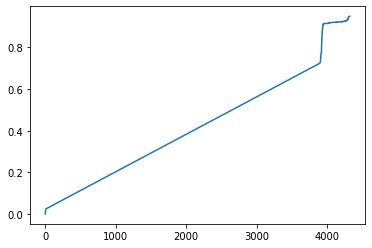

In [ ]:
import matplotlib.pyplot as plt

# plt.plot([0,max(fppi)], [0,max(tpr)], linestyle="--")
plt.plot(fppi, tpr)

In [ ]:
if __name__== "__main__":
  main()

In [ ]:
# When we find the best fit, we can put everything into a pipeline

pipe = Pipeline([('standard', StandardScaler()),
                 ('classifier', KNeighborsClassifier(n_neighbors=5))])

pipe.fit(X_train, y_train)
score = pipe.predict(X_test)
accuracy_score(y_test, score)

**Auxiliar Functions**

In [ ]:
# function to get connected components of the ground truth binary image
import cv2

def componentsStatsGroundTruth(matrix):
  dict_stat = dict()

  # getting the info of the components in the ground truth
  # second value is connectivity 4 or 8
  connectedComponentsGroundTruth = cv2.connectedComponentsWithStats(matrix, 8, cv2.CV_32S)

  # Get the results
  # The first cell is the number of labels
  num_labels = connectedComponentsGroundTruth[0]
  # The second cell is the label matrix
  labels = connectedComponentsGroundTruth[1]
  
  
  # The third cell is the stat matrix

# if it is not register as normal
# stat have 5 items: leftmost x coordinate,
#                    topmost y coordinate,
#                    horizontal size of the bounding box
#                    vertical size of the bounding box
#                    total area in pixels of the connected component

  stats = connectedComponentsGroundTruth[2]
  for stat in range(len(stats)):
    dict_stat[stat] = {}
    dict_stat[stat]["leftmost_x"] = stats[stat][0]
    dict_stat[stat]["topmost_y"] = stats[stat][1]
    dict_stat[stat]["hor_size"] = stats[stat][2]
    dict_stat[stat]["vert_size"] = stats[stat][3]
    dict_stat[stat]["total_ares"] = stats[stat][4]

  # The fourth cell is the centroid matrix
  dict_centroid = dict()
  centroids = connectedComponentsGroundTruth[3]
  for i in range(len(centroids)):
    dict_centroid[i] = {}
    dict_centroid[i]["x"] = centroids[i][0]
    dict_centroid[i]["y"] = centroids[i][1]

  return num_labels, labels, dict_stat, dict_centroid

In [ ]:
import pandas as pd
import gc
import json

def create_groundTruthStatsFile(groundTruths):

  gTComponents = pd.DataFrame()
  flag = True

  for groundTruth in groundTruths:

    gTComponents = pd.DataFrame()

    imgGroundTruth = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', groundTruth), cv2.IMREAD_GRAYSCALE)

    num_labels, labels, stats, centroids = componentsStatsGroundTruth(imgGroundTruth)
    
    # if it is not register as normal
    # stat have 5 items: leftmost x coordinate,
    #                    topmost y coordinate,
    #                    horizontal size of the bounding box
    #                    vertical size of the bounding box
    #                    total area in pixels of the connected component

    gTComponents['stats'] = [stats] 
    gTComponents['centroids'] = [centroids]
    gTComponents['num_labels'] = num_labels
    gTComponents['name'] = groundTruth

    if(flag):
      gTComponents.to_csv(os.path.join('/content',
                                  'drive',
                                  'MyDrive',
                                  'Results',
                                  'groundTruthStats.csv'),
                      mode='a',
                      index=False)
      flag = False
    else:
      gTComponents.to_csv(os.path.join('/content',
                                  'drive',
                                  'MyDrive',
                                  'Results',
                                  'groundTruthStats.csv'),
                    mode='a',
                    header=False,
                    index=False)
    
    del num_labels, labels, stats, centroids
    gc.collect()
  
  return


Chaos zone

In [ ]:
# # def main():

# from sklearn.metrics import classification_report
# from sklearn.metrics import accuracy_score
# import copy

# classifier = ''

# #Reading data
# dfs_train, dfs_test = read_results_train_test(RESULTS_DIR)

# #Preprocessing steps
# #Manage unbalanced data
# # dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

# labels = dfs_train['label'].reset_index(drop=True)
# candidates = dfs_train[['name', 'label', 'x', 'y', 'sigma']]
# data = dfs_train.drop(['name', 'label',  'x', 'y', 'sigma'], axis=1).reset_index(drop=True)

# #Plot features 
# #  plotFeatures(data)

# #Obtain train-test datasets
# if classifier == "SVM_SEL":
#   counter = 0
#   print('Len of negative pool: ',len(dfNegative))
#   X_train, X_test, y_train, y_test, candidates_train, candidates_test = train_test_split(data, labels, candidates, test_size=0.5,  stratify=labels,random_state=42)  

#   # Normalization steps
#   X_train, X_test = standardScaler(X_train, X_test)

#   #Feature Engineering - PCA, LDA, choose-k, etc
#   # X_train, X_test = pcaAnalysis(10, X_train, X_test)

#   trainDataFull = pd.DataFrame(X_train)
#   print(trainDataFull)
#   trainDataFull['label'] = y_train

#   dataBalanced, dfNegative = rus(trainDataFull)

# #  while len(dfNegative)>(len(dataBalanced)/2)
#   while True:

#     #Classification

#     trainBalanceData = dataBalanced.drop('label', axis=1)
#     trainBalanceLabel = dataBalanced['label']

#     if counter == 0:
#       print("Trying SMV SEL...")
#       best_params = SVM_SEL(13, -2, 10, trainBalanceData, trainBalanceLabel)
#       clf = SVC(**best_params)

#     clf.fit(trainBalanceData, trainBalanceLabel)
#     pred = clf.predict(dfNegative.drop('label', axis=1))

#     y_pred = clf.predict(X_test)
#     print('accuracy: ', accuracy_score(y_test, y_pred))
#     print(classification_report(y_test, y_pred))

#     cvScore = cross_val_score(clf, data, labels, cv=2)
#     print(cvScore)
#     print("Mean CV_score accuracy: ", np.mean(cvScore))


#     misclassified = pd.DataFrame(columns = data.columns)
#     labels_pool = []
#     for i in range(len(pred)):
#       if (pred[i]==1) & (dfNegative['label'].iloc[i] == 0): #FP False positive
# #        new_row = pd.DataFrame(X_test[i].reshape(1, data.shape[1] ), columns=data.columns)
#         new_row = dfNegative.drop('label', axis=1).iloc[i]
#         misclassified = misclassified.append(new_row)
#         labels_pool.append(dfNegative['label'].iloc[i])

#     newData_1 = dataBalanced.loc[dataBalanced.label == 1]

#     dataBalanced, dfNegative = rus(newData_1.append(dfNegative), len(misclassified))
#     trainBalanceLabel = dataBalanced['label'].append(pd.Series(labels_pool))
#     trainBalanceData = dataBalanced.drop(['label'], axis=1).append(misclassified)
#     print('Data len: ', len(data))
#     print('labels len: ', len(labels))
#     counter +=1

# else:

#   dataBalanced, dfNegative = rus(dfs) #Random majority undersampling

#   labels = dataBalanced['label'].reset_index(drop=True)
#   data = dataBalanced.drop(['name', 'label'], axis=1).reset_index(drop=True)  
#   candidates = dataBalanced[['name', 'label', 'x', 'y', 'sigma']]

#   X_train, X_test, y_train, y_test, candidates_train, candidates_test = train_test_split(data, labels, candidates, test_size=0.5,  shuffle=False, random_state=42)  

#   # Normalization steps
#   X_train, X_test = standardScaler(X_train, X_test)


#   # SVC_linear(5, -2,2, 10, data, labels)
#   predDT = DecisionTree(X_train, X_test, y_train, y_test, data, labels)
#   predKNN = KNN(5, X_train, X_test, y_train, y_test, data, labels)


#   groundTruthsDataFrame = pd.read_csv(os.path.join('/content',
#                                 'drive',
#                                 'MyDrive',
#                                 'Results',
#                                 'groundTruthStats.csv'))
  

  

#   # read numbers of normal images
#   normals = []
#   with open(os.path.join(DATA_DIR,'normals.txt')) as f:
#       for line in f:
#           normals.append(line[:-1])

#   candidates_unique = [cand.split('_')[2] for cand in candidates_test.name.values.tolist()]
#   candidates_unique = list(set(candidates_unique))
#   df_candidates_unique = pd.DataFrame()
#   df_candidates_unique['key'] = candidates_unique

#   groundTruthsDataFrame['key'] = [i.split('_')[0] for i in groundTruthsDataFrame.name.values.tolist()]

# groundTruthsDataFrame.join(df_candidates_unique.set_index('key'), on='key', how='right')





#   # calculateFROC(groundTruthsDataFrame, normals, candidates_test, predKNN, 'KNN', '4')




In [ ]:
# import pandas as pd
# import os
# #!pip install fastprogress
# from fastprogress import master_bar, progress_bar
# #!pip install tqdm
# from tqdm.notebook import tqdm_notebook
# from skimage import measure
# from matplotlib import pyplot as plt



# def calculateFROC(groundTruthsList, normals, candidates, prediction, model, pipeline):



# #List needed for counting
#   evaluationList = []

#   # evaluation froc curve #

#   fn = 0 # false negative, for the blobs that do not belong to any component
#   positive_candidates = 0
#   flag = True

#   rowListdfROC = []


#   candidates_copy= candidates.copy()
#   candidates_copy['prediction'] = prediction

#   for imageKey in tqdm_notebook(groundTruthsList):



#     evaluationList = []

 
#     # list of features found with y,x and sigma
#     candidatesImg = candidates_copy.loc[candidates_copy['name'].str.contains(imageKey.split('_')[0], regex=False)]
#     candidates_number = len(candidatesImg)
#     print('cand number: ', candidates_number)

#     mask = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', imageKey), cv2.IMREAD_GRAYSCALE)


#     print('# IMAGEKEY: ', imageKey)
#     blobs = mask > 0.7 * mask.mean()
#     blobs_labels, count = measure.label(blobs, background=0, return_num=True)

#     # dictionaries
#     dictCounting={}

#     print(count)
#     for index in range(1, count+1):
#       dictCounting[index] = 0
    
#     evaluationList = []

#     for index2, candidate in candidatesImg.iterrows():

#       if (imageKey.split('_')[0] in normals):
#         rowListdfROC.append(['FP', candidate.prediction])  
#         continue
#       # is the image a normal image?

#       # n = 3
#       left = int((candidate.x - candidate.sigma) if ((candidate.x - candidate.sigma) > 0) else 0)
#       right = int((candidate.x + candidate.sigma) if ((candidate.x + candidate.sigma) < mask.shape[1]) else mask.shape[1])
#       top = int((candidate.y - candidate.sigma) if ((candidate.y - candidate.sigma) > 0) else 0)
#       bottom = int((candidate.y + candidate.sigma) if ((candidate.y + candidate.sigma) < mask.shape[0]) else mask.shape[0])

#       #    y : y + w , x : x +  h
#       nonzero = cv2.countNonZero(blobs_labels[top:bottom, left: right])

#       if nonzero > 0:
#         foundCC = [i for i in np.unique(blobs_labels[top:bottom, left: right]) if i!= 0]

#         for cc in foundCC:
#           dictCounting[cc] = max(candidate.prediction, dictCounting[cc])
#       else:
#         rowListdfROC.append(['FP', candidate.prediction])  

#     for key,value in dictCounting.items():
#       if value > 0:
#         rowListdfROC.append(['TP', value])
#       else:
#         fn = fn + 1


#   dfROC = pd.DataFrame(rowListdfROC, columns=['type', 'prob'])

#   dfROC.to_csv(os.path.join('/content',
#                                 'drive',
#                                 'MyDrive',
#                                 'Results',
#                                 'FROC_calculations_{}_pip{}_fn{}_normals{}.csv'.format(model, pipeline, fn, len(normals))))



#   return fn, dfROC

In [ ]:
# import cv2
# from skimage import measure

# mask = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', '20586908_6c613a14b80a8591_MG_R_CC_ANON.tif'), cv2.IMREAD_GRAYSCALE)
# # candidates = 

# contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
# bounding_boxes = [cv2.boundingRect(contour) for contour in contours]


# blobs = mask > 0.7 * mask.mean()
# blobs_labels, count = measure.label(blobs, background=0, return_num=True)
# print('blobs_labels ', blobs_labels)
# print('count ', count)
# plt.imshow(blobs_labels, cmap='gray')


# print(contours[0])

# # pts = np.array([[3428, 2964]])
# pts = np.array([[2962, 3426]])
# pts = pts.reshape((-1,1,2))

# if (cv2.pointPolygonTest(contours[0], (2959, 3422), False) > 0):
#   print("coincidencia")


# # for box in bounding_boxes:
# #   x=box[0]
# #   y=box[1]
# #   w=box[2]
# #   h=box[3]
# #   for y in range(y, y+h):
# #     for x in range(x, x+w):
# #       if (cv2.pointPolygonTest(contours[2], (x, y), False) > 0):
# #         print("coincidencia")
#       # print(cv2.pointPolygonTest(pts, (x, y), False))
